# Example
from: https://github.com/sciann/sciann-applications/tree/master/SciANN-SolidMechanics

In [2]:
""" SciANN-SolidMechanics.py
Description:
    SciANN code for solution and discovery of solid mechanics from data.
    For additional details, please check our paper at: https://arxiv.org/abs/2003.02751
    
Created by Ehsan Haghighat on 2/14/20.
"""

import os, sys, time
import numpy as np
from sciann.utils.math import diff
from sciann import SciModel, Functional, Parameter
from sciann import Data, Tie
from sciann import Variable, Field
import netCDF4
import xarray as xr

import matplotlib.pyplot as plt
import argparse
pi = np.pi 

## Parameters

In [3]:
# current file name. 
#current_file_name = os.path.basename(__file__).split(".")[0]
current_file_name = 'SciANN-SolidMechanics_Sam.ipynb'

# Lame paramters used in the paper. 
lmbd = 120.0
mu = 80.0
qload = 4.0

In [17]:
'''
# Input interface for python. 
parser = argparse.ArgumentParser(description=
        #SciANN code for solution and discovery of solid mechanics from data. \n 
        #For additional details, please check our paper at: https://arxiv.org/submit/3042511
)

# Define number of data points.
parser.add_argument('-l', '--layers', help='Num layers and neurons (default 4 layers each 40 neurons [40, 40, 40, 40])', type=int, nargs='+', default=[40]*4)
parser.add_argument('-af', '--actf', help='Activation function (default tanh)', type=str, nargs=1, default=['tanh'])
parser.add_argument('-nx', '--numx', help='Num Node in X (default 40)', type=int, nargs=1, default=[20])
parser.add_argument('-ny', '--numy', help='Num Node in Y (default 40)', type=int, nargs=1, default=[20])
parser.add_argument('-bs', '--batchsize', help='Batch size for Adam optimizer (default 32)', type=int, nargs=1, default=[32])
parser.add_argument('-e', '--epochs', help='Maximum number of epochs (default 2000)', type=int, nargs=1, default=[5000])
parser.add_argument('-lr', '--learningrate', help='Initial learning rate (default 0.001)', type=float, nargs=1, default=[0.001])
parser.add_argument('-in', '--independent_networks', help='Use independent networks for each var (default True)', type=bool, nargs=1, default=[True])
parser.add_argument('-v', '--verbose', help='Show training progress (default 2) (check Keras.fit)', type=int, nargs=1, default=[2])

parser.add_argument('--shuffle', help='Shuffle data for training (default True)', type=bool, nargs=1, default=[True])
parser.add_argument('--stopafter', help='Patience argument from Keras (default 500)', type=int, nargs=1, default=[500])
parser.add_argument('--savefreq', help='Frequency to save weights (each n-epoch)', type=int, nargs=1, default=[100000])
parser.add_argument('--dtype', help='Data type for weights and biases (default float64)', type=str, nargs=1, default=['float64'])
parser.add_argument('--gpu', help='Use GPU if available (default False)', type=bool, nargs=1, default=[False])
parser.add_argument('-op', '--outputpath', help='Output path (default ./file_name)', type=str, nargs=1, default=['output'])
parser.add_argument('-of', '--outputprefix', help='Output path (default res**)', type=str, nargs=1, default=['res'])

parser.add_argument('-nxp', '--numxplot', help='Num Node in X for ploting final results (default 200)', type=int, nargs=1, default=[200])
parser.add_argument('-nyp', '--numyplot', help='Num Node in Y for ploting final results (default 200)', type=int, nargs=1, default=[200])
parser.add_argument('--plot', help='Plot the model', nargs='?', default=False)

args = parser.parse_args()
'''
        
        
layers = [40]*4
actf = 'tanh'
numx = 46
numy = 60
batchsize = 32
#batchsize = 16
epochs = 1000
learningrate = 0.01
independent_networks = True
verbose = 2
shuffle = True
stopafter = 500
savefreq = 100000
dtype = 'float64'
gpu = False
outputpath = 'output2'
outputprefix = 'res'
numxplot = 46
numyplot = 60
plot = True

data_file = '../abaqus/final_elastic/elastic_cdf.nc'
set = xr.open_dataset(data_file)
node_file = '../abaqus/final_elastic/nodes.txt'

## Functions

In [18]:
'''
def load(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return Q * np.sin(pi*x)


def bodyfx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = - lmbd*(4*pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - mu*(pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - 8*mu*pi**2*np.cos(2*pi*x)*np.sin(pi*y)
    return frc


def bodyfy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = lmbd*(3*Q*y**2*np.sin(pi*x) - 2*pi**2*np.cos(pi*y)*np.sin(2*pi*x)) \
          - mu*(2*pi**2*np.cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*np.sin(pi*x))/4) \
          + 6*Q*mu*y**2*np.sin(pi*x)
    return frc
'''

def dispx(set): # xx
    #x, y = xx[0], xx[1]
    disp_x = np.asarray(set.sel(field='ux').to_array())
    return disp_x #np.cos(2*pi*x) * np.sin(pi*y)


def dispy(set): # xx
    #x, y = xx[0], xx[1]
    #Q = qload
    disp_y= np.asarray(set.sel(field='uy').to_array())
    return disp_y #np.sin(pi*x) * Q * y**4/4

'''
def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x)*Q*y**3


def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)
'''

def stressxx(set): # xx
    return np.asarray(set.sel(field='S11').to_array())
    #set.sel(field='S11').to_array() #(lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(set): # xx
    return np.asarray(set.sel(field='S22').to_array())
    #return set.sel(field='S22').to_array() #(lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(set): # xx
    return np.asarray(set.sel(field='S12').to_array())
    #return set.sel(field='S21').to_array() #2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

# Create function to read text files in as np array
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)

def rearrange(numx, numy, field):
    stuff = np.zeros([numx,numy])
    for k,f in enumerate(field):
        i = int(k % numx)
        j = int(np.floor(k/numx))
        stuff[i,j] = f
        
    stuff = stuff.T
    return(stuff)
    

## Training model

In [19]:
def train():
    # define output folder. 
    if not os.path.isdir(outputpath):
        os.mkdir(outputpath)
        
    output_file_name = os.path.join(outputpath, outputprefix)
    fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    
    # Neural Network Setup.
    x = Variable("x", dtype=dtype)
    y = Variable("y", dtype=dtype)

    if independent_networks:
        Uxy = Functional("Uxy", [x, y], layers, actf)
        Vxy = Functional("Vxy", [x, y], layers, actf)
        Sxx = Functional("Sxx", [x, y], layers, actf)
        Syy = Functional("Syy", [x, y], layers, actf)
        Sxy = Functional("Sxy", [x, y], layers, actf)

    else:
        Uxy, Vxy, Sxx, Syy, Sxy = Functional(
            ["Uxy", "Vxy", "Sxx", "Syy", "Sxy"],
            [x, y],
            layers, act).split()
    
    lame1 = Parameter(115.0, inputs=[x,y], name="lame1")
    lame2 = Parameter(75.0, inputs=[x,y], name="lame2")

    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    Exx = diff(Uxy, x)
    Eyy = diff(Vxy, y)
    Exy = (diff(Uxy, y) + diff(Vxy, x))*0.5

    # Define constraints 
    d1 = Data(Uxy)
    d2 = Data(Vxy)
    d3 = Data(Sxx)
    d4 = Data(Syy)
    d5 = Data(Sxy)
    
    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)
    c3 = Tie(Sxy, Exy*C33)
    
    Lx = diff(Sxx, x) + diff(Sxy, y)
    Ly = diff(Sxy, x) + diff(Syy, y)
    
    # Define the optimization model (set of inputs and constraints)
    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse"
    )
    with open("{}_summary".format(fname), "w") as fobj:
        model.summary(print_fn=lambda x: fobj.write(x + '\n'))
        
    # Prepare training data 
    ## Training grid 
    XMIN, XMAX = 0.0, 3000.0
    YMIN, YMAX = -1500.0, 1500.0
    Xmesh = np.linspace(XMIN, XMAX, numx).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, numy).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)

    #input_data = [X.reshape(-1, 1), Y.reshape(-1, 1)]
    #print(input_data)
    #print(np.shape(input_data))
    nodal_coordinates = file2array(node_file)
    grid = nodal_coordinates[:,1:3].T
    grid = np.expand_dims(grid, axis=0)
    grid = np.moveaxis(grid, 0, -1)
    print(np.shape(grid))

    ## data associated to constrains defined earlier 
    # Define constraints 
    input_d = set.step_080
    data_d1 = np.asarray(input_d.sel(field='ux'))
    data_d2 = np.asarray(input_d.sel(field='uy'))
    data_d3 = np.asarray(input_d.sel(field='S11'))
    data_d4 = np.asarray(input_d.sel(field='S22'))
    data_d5 = np.asarray(input_d.sel(field='S12'))
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    #data_Lx = 'zeros' #bodyfx(input_data)
    #data_Ly = 'zeros' #bodyfy(input_data)
    
    data_Lx = np.zeros([numx*numy,1])
    data_Ly= np.zeros([numx*numy,1])
    
    data_d1 = np.expand_dims(data_d1, axis=0).T
    data_d2 = np.expand_dims(data_d2, axis=0).T
    data_d3 = np.expand_dims(data_d3, axis=0).T
    data_d4 = np.expand_dims(data_d4, axis=0).T
    data_d5 = np.expand_dims(data_d5, axis=0).T
    
    print(np.shape(data_d1))
    
    target_data = [data_d1, data_d2, data_d3, data_d4, data_d5, 
                   data_c1, data_c2, data_c3,
                   data_Lx, data_Ly]
    
    #print(np.shape(target_data))
    print(np.shape(grid))
    input_data = [grid[0],grid[1]]

    fname_out = fname +'_WEIGHTS'
    # Train the model 
    training_time = time.time()
    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs=epochs,
        batch_size=batchsize,
        shuffle=shuffle,
        learning_rate=learningrate,
        stop_after=stopafter,
        verbose=verbose,
        #save_weights_to=fname_out,
        #save_weights_freq=savefreq
    )
    training_time = time.time() - training_time

    for loss in history.history:
        np.savetxt(fname+"_{}".format("_".join(loss.split("/"))), 
                    np.array(history.history[loss]).reshape(-1, 1))
    
    time_steps = np.linspace(0, training_time, len(history.history["loss"]))
    np.savetxt(fname+"_Time", time_steps.reshape(-1,1))

    # Post process the trained model.
    Xmesh_plot = np.linspace(XMIN, XMAX, numxplot).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, numyplot).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]

    lame1_pred = lame1.eval(model, input_plot)
    lame2_pred = lame2.eval(model, input_plot)
    Uxy_pred = Uxy.eval(model, input_plot)
    Vxy_pred = Vxy.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)
        
    np.savetxt(fname+"_Xmesh", X_plot, delimiter=', ')
    np.savetxt(fname+"_Ymesh", Y_plot, delimiter=', ')
    np.savetxt(fname+"_lame1", lame1_pred, delimiter=', ')
    np.savetxt(fname+"_lame2", lame2_pred, delimiter=', ')
    np.savetxt(fname+"_Uxy", Uxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Vxy", Vxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exx", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Eyy", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exy", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxx", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Syy", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxy", Sxy_pred.reshape(X_plot.shape), delimiter=', ')

In [20]:
def plot():
    output_file_name = os.path.join(outputpath, outputprefix)
    fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    
    loss = np.loadtxt(fname+"_loss")
    time = np.loadtxt(fname+"_Time")
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], time, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_loss.png".format(output_file_name))
    
    Xmesh = np.loadtxt(fname+"_Xmesh", delimiter=',')
    Ymesh = np.loadtxt(fname+"_Ymesh", delimiter=',')
    
    input_d = set.step_080
    data_d1 = np.asarray(input_d.sel(field='ux'))
    data_d2 = np.asarray(input_d.sel(field='uy'))
    data_d3 = np.asarray(input_d.sel(field='S11'))
    data_d4 = np.asarray(input_d.sel(field='S22'))
    data_d5 = np.asarray(input_d.sel(field='S12'))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, "L*={:.3f}".format(lmbd))
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu, "G*={:.3f}".format(mu))
    lmbd_pred = np.loadtxt(fname+"_lame1", delimiter=',')
    mu_pred = np.loadtxt(fname+"_lame2", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd_pred, "L={:.3f}".format(lmbd_pred.mean()))
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu_pred, "G={:.3f}".format(mu_pred.mean()))
    plt.savefig("{}_Parameters.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    plot_ux = rearrange(numx, numy, np.asarray(input_d.sel(field='ux')))
    plot_uy = rearrange(numx, numy, np.asarray(input_d.sel(field='uy')))
    print(np.shape(np.loadtxt(fname+"_Uxy", delimiter=',')))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_ux, "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_uy, "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Uxy", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Vxy", delimiter=','), "Uy")
    plt.savefig("{}_Displacement.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    plot_s11 = rearrange(numx, numy, np.asarray(input_d.sel(field='S11')))
    plot_s22 = rearrange(numx, numy, np.asarray(input_d.sel(field='S22')))
    plot_s12 = rearrange(numx, numy, np.asarray(input_d.sel(field='S12')))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_s11, "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_s22, "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, plot_s12, "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Sxx", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Syy", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Sxy", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_Stress.png".format(output_file_name))
    
    #fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    #cust_pcolor(ax[0, 0], Xmesh, Ymesh, strainxx([Xmesh, Ymesh]), "Exx*")
    #cust_pcolor(ax[0, 1], Xmesh, Ymesh, strainyy([Xmesh, Ymesh]), "Eyy*")
    #cust_pcolor(ax[0, 2], Xmesh, Ymesh, strainxy([Xmesh, Ymesh]), "Exy*")
    #cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Exx", delimiter=','), "Exx")
    #cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Eyy", delimiter=','), "Eyy")
    #cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Exy", delimiter=','), "Exy")
    #fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    #plt.savefig("{}_Strain.png".format(output_file_name))

## Run it

(2, 2760, 1)
(2760, 1)
(2, 2760, 1)

Total samples: 2760 
Batch size: 32 
Total batches: 87 

Epoch 1/1000
87/87 - 3s - loss: 18186.8992 - Uxy_loss: 1.1556 - Vxy_loss: 0.4782 - Sxx_loss: 0.0658 - Syy_loss: 17576.5914 - Sxy_loss: 0.0582 - sub_4_loss: 2.7059 - sub_5_loss: 586.0905 - sub_6_loss: 0.6707 - add_11_loss: 1.8654e-05 - add_12_loss: 8.7079e-06 - lr: 0.0100 - time: 2.6829
Epoch 2/1000
87/87 - 0s - loss: 13511.8963 - Uxy_loss: 1.3207 - Vxy_loss: 4.3509 - Sxx_loss: 0.0431 - Syy_loss: 10956.3344 - Sxy_loss: 0.0261 - sub_4_loss: 4.2266 - sub_5_loss: 2535.2198 - sub_6_loss: 1.1815 - add_11_loss: 1.5983e-06 - add_12_loss: 1.6543e-06 - lr: 0.0100 - time: 0.3343
Epoch 3/1000
87/87 - 0s - loss: 12022.5135 - Uxy_loss: 1.3207 - Vxy_loss: 7.0059 - Sxx_loss: 0.0801 - Syy_loss: 7600.7161 - Sxy_loss: 0.0154 - sub_4_loss: 8.4076 - sub_5_loss: 4403.3244 - sub_6_loss: 1.0376 - add_11_loss: 3.6584e-05 - add_12_loss: 1.3165e-06 - lr: 0.0100 - time: 0.3741
Epoch 4/1000
87/87 - 0s - loss: 11811.9827 -

/tmp/ipykernel_4415/3498568546.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = AX.pcolor(X, Y, C, cmap="jet")


(60, 46)


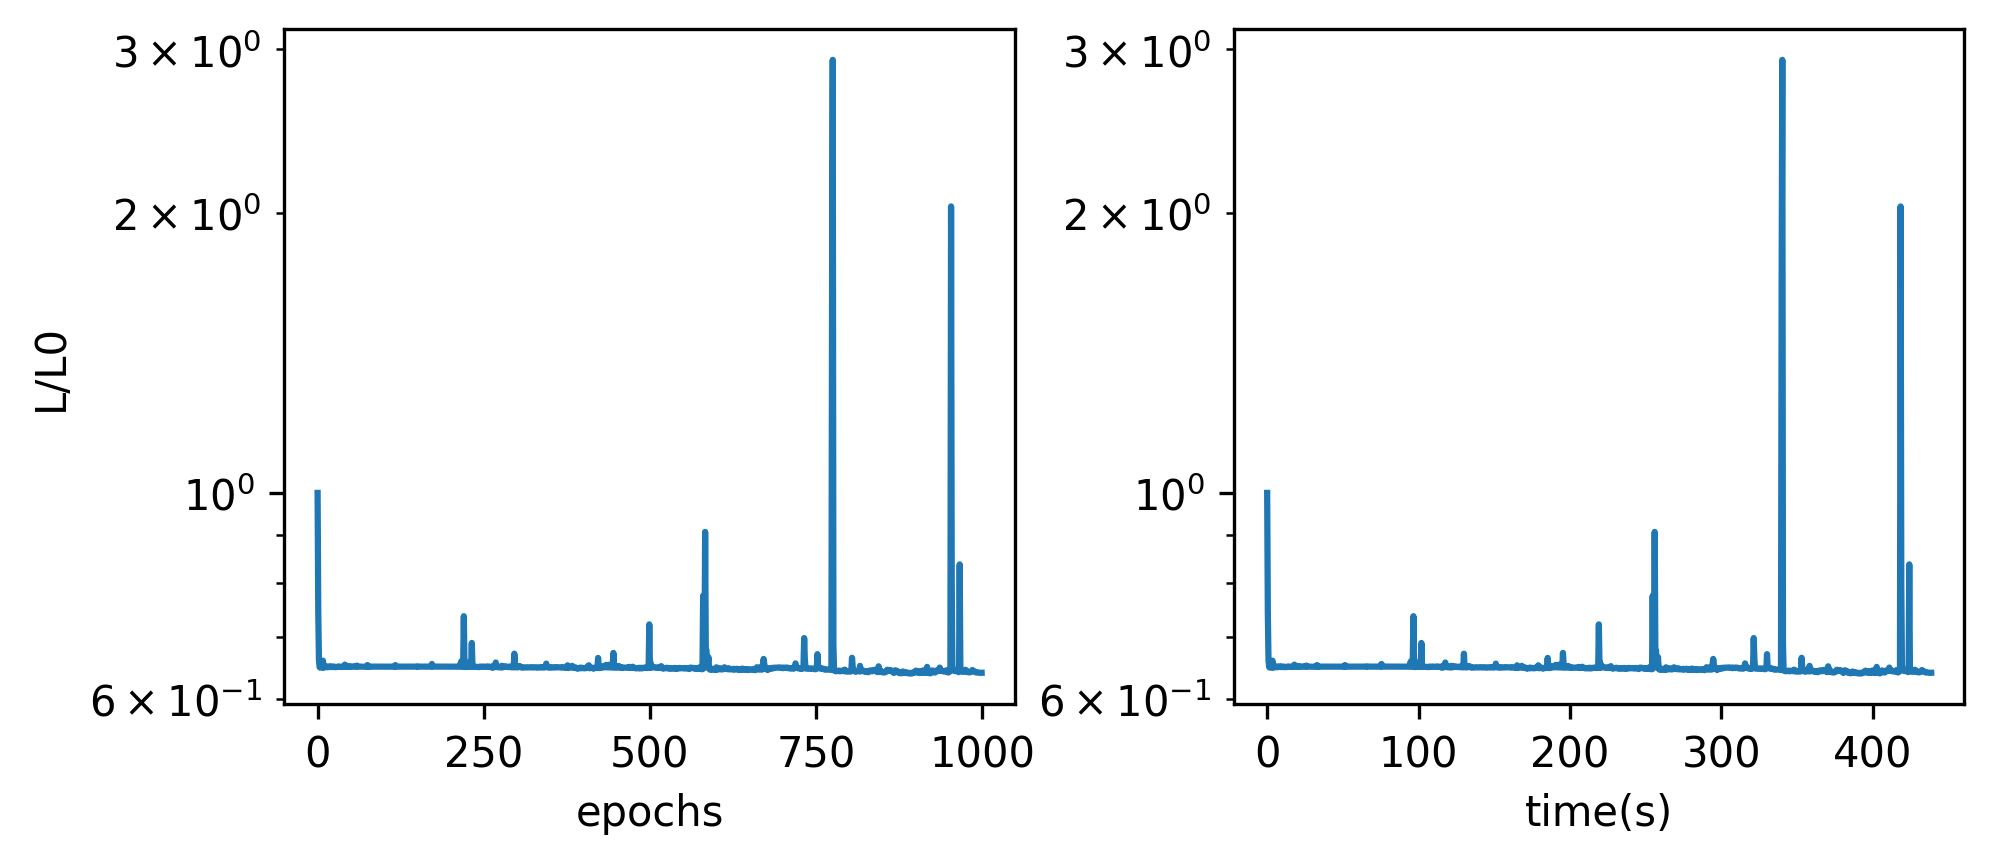

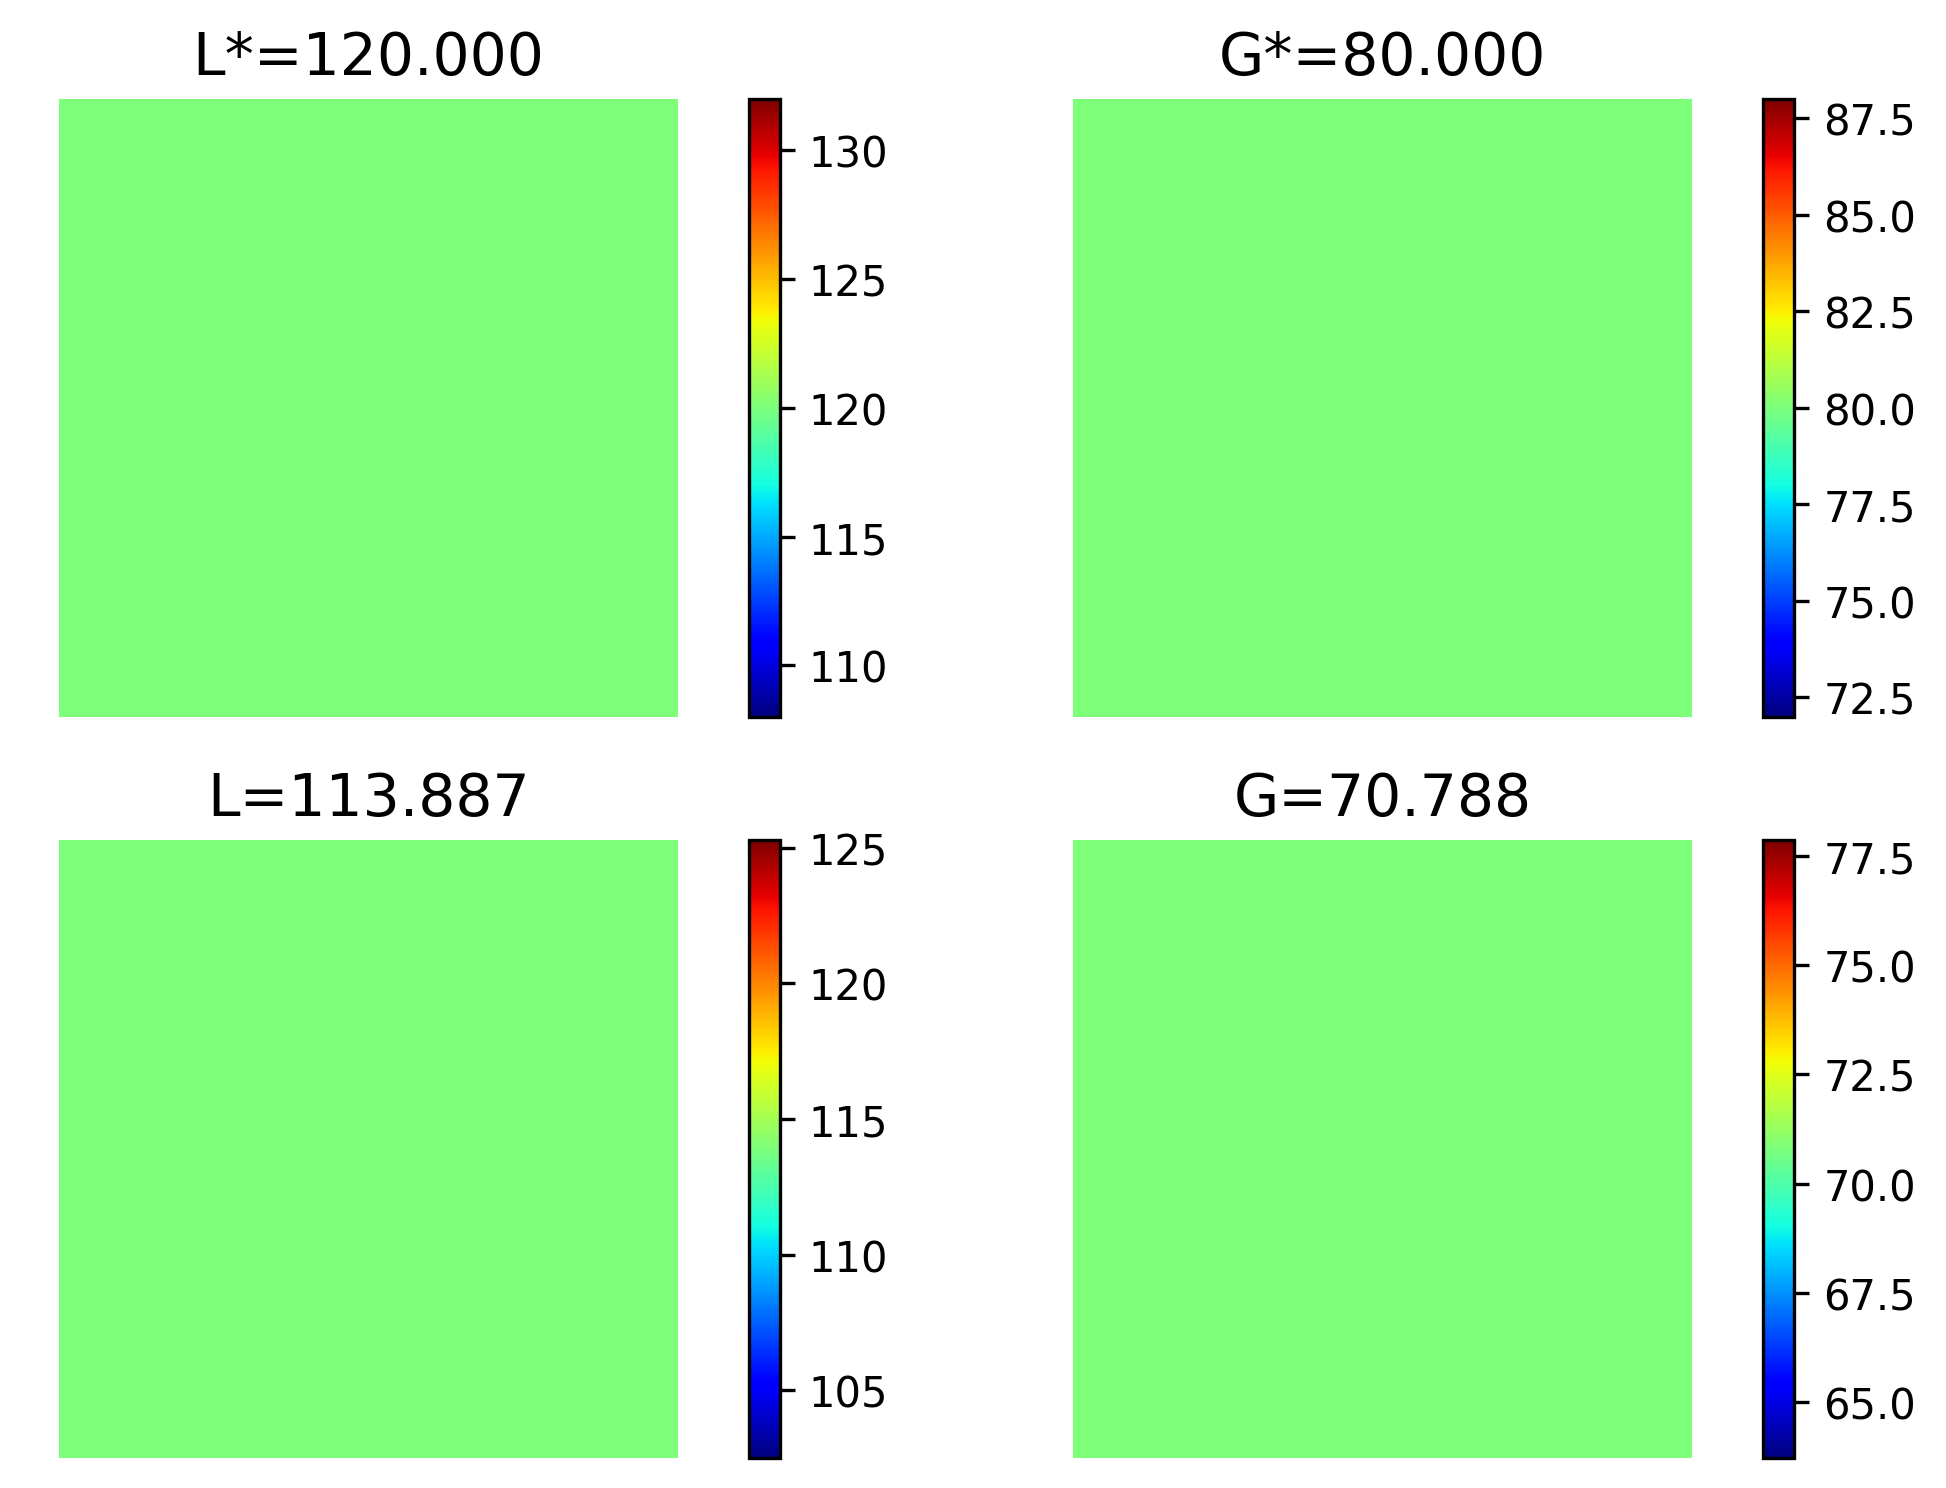

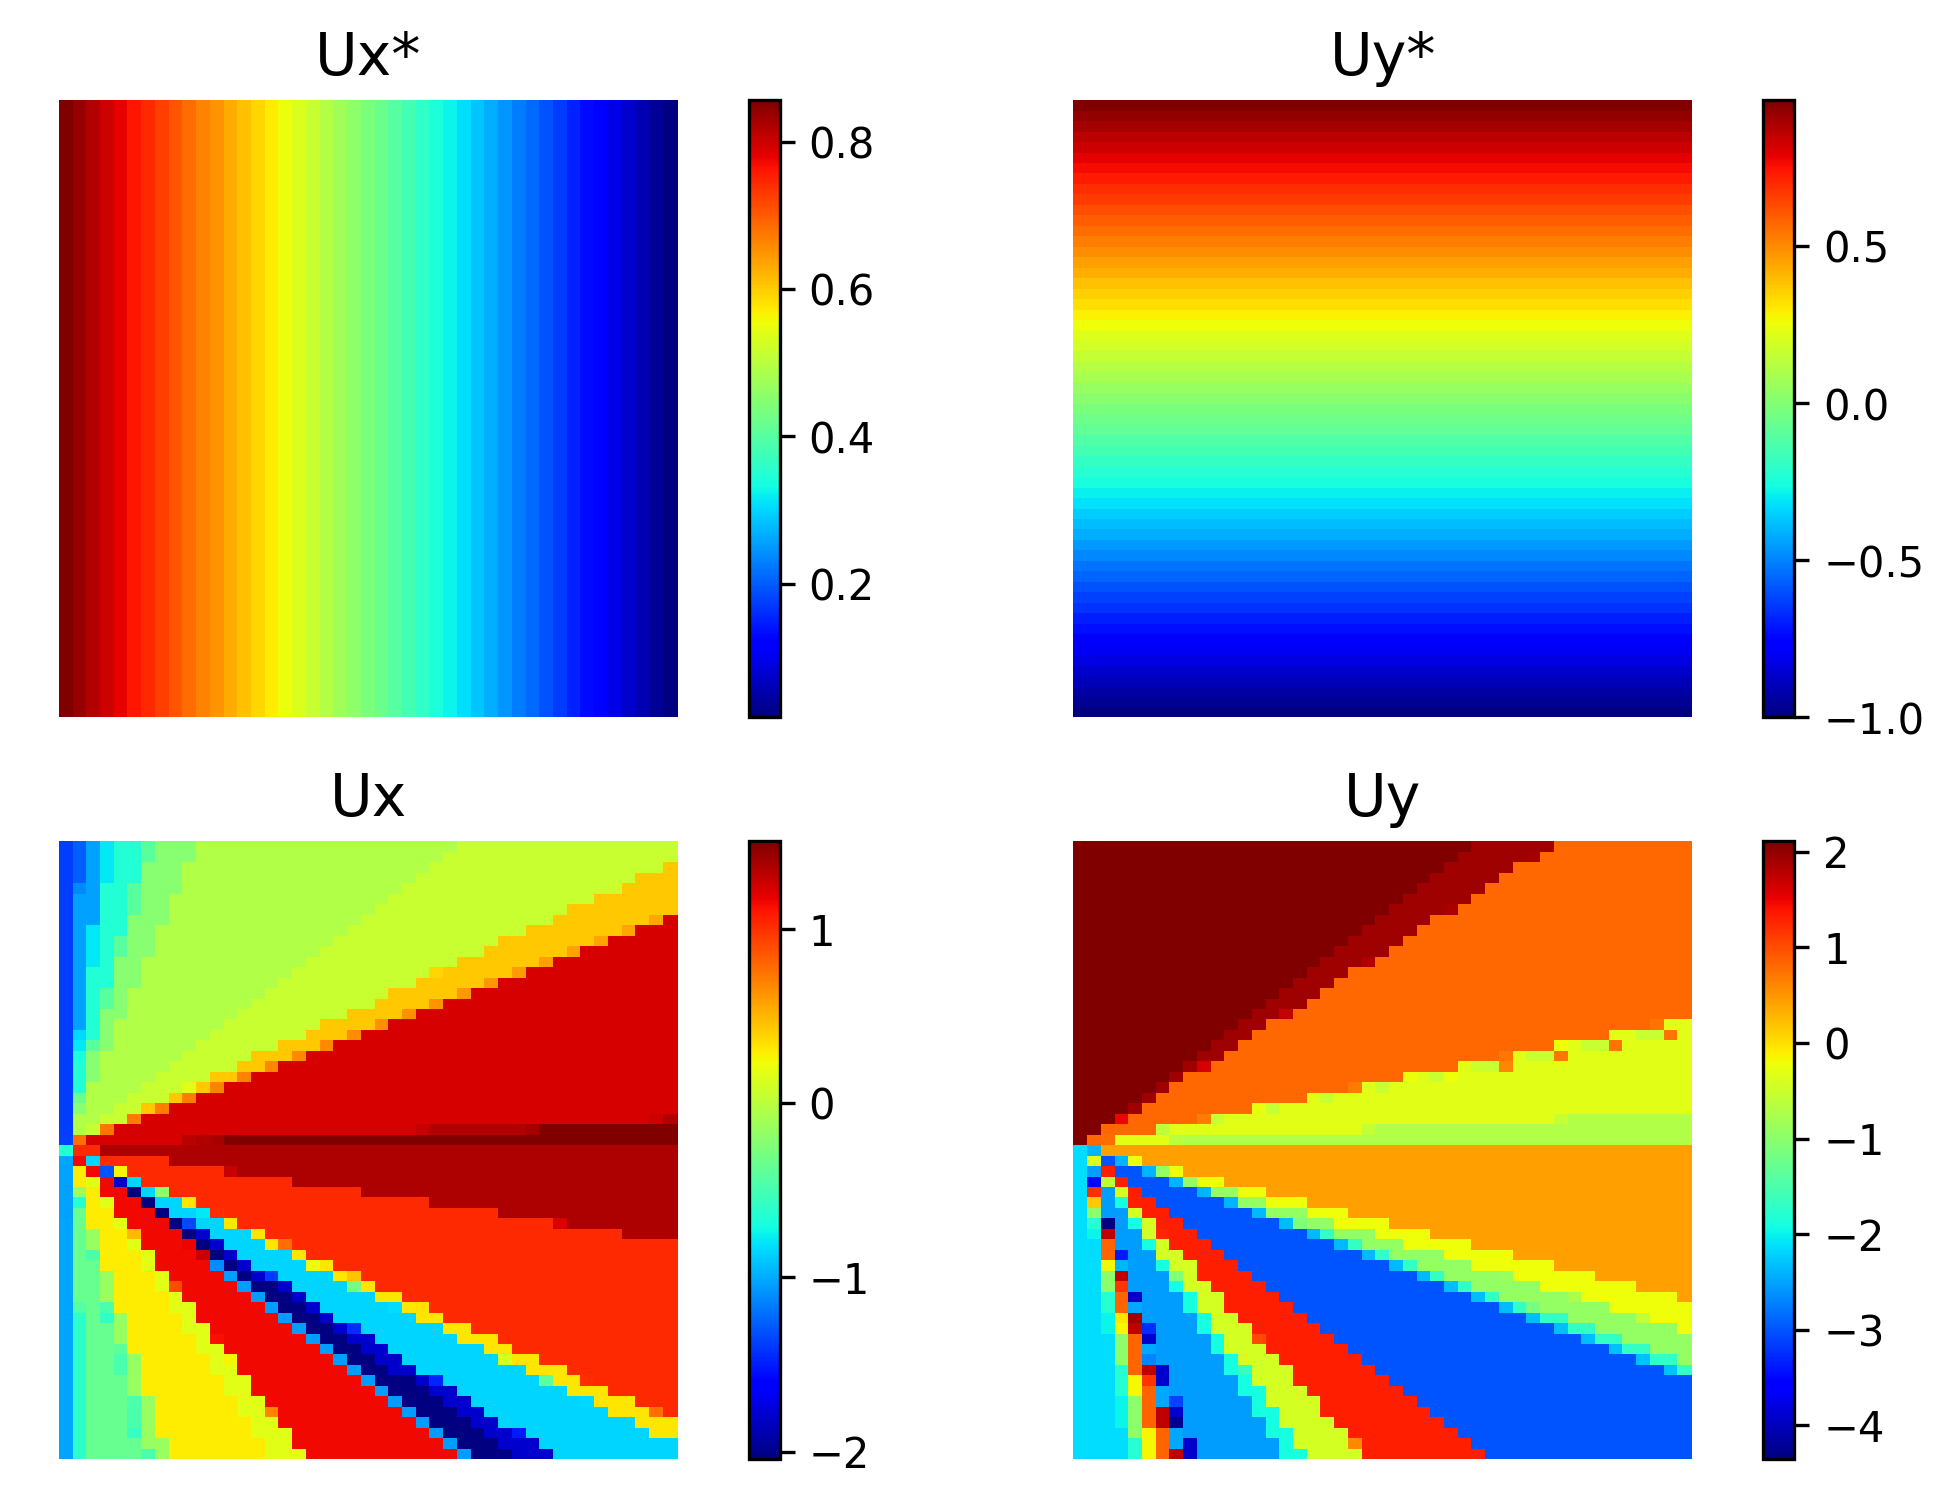

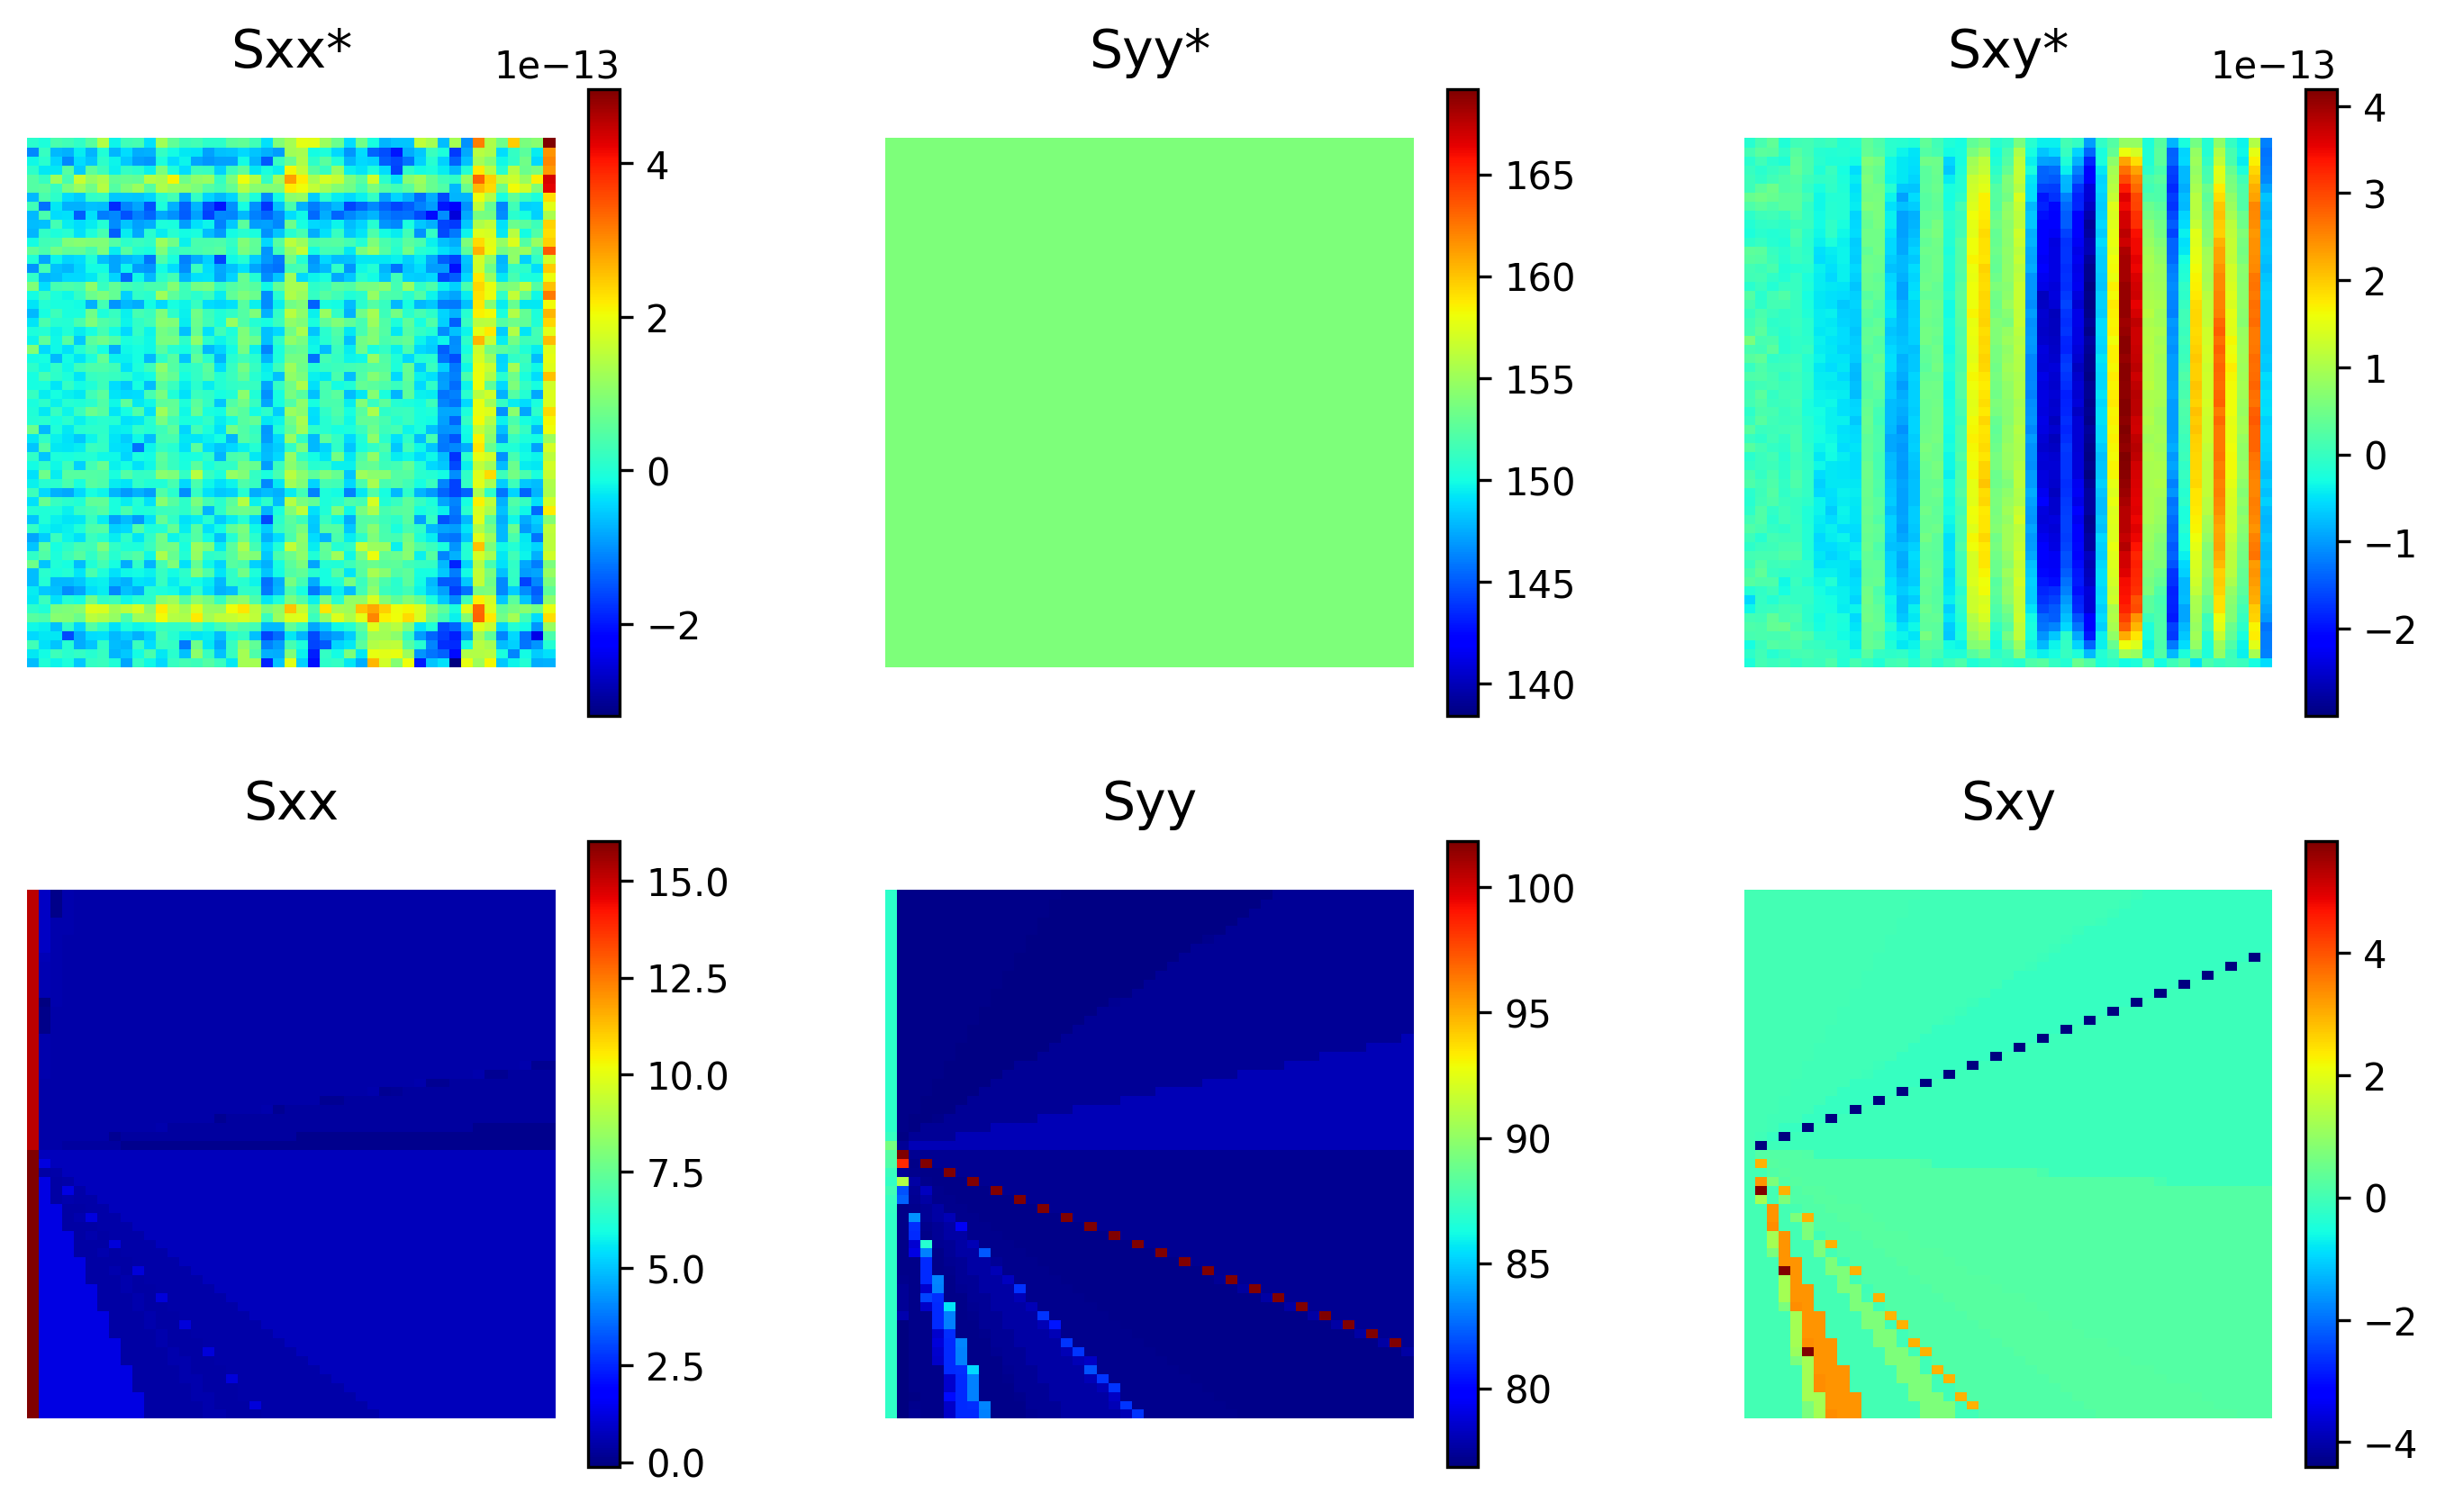

In [21]:
train()
plot()

In [ ]:
input_data = set.step_080
np.asarray(input_data.sel(field='ux'))
plot_s11 = rearrange(numx, numy, np.asarray(input_data.sel(field='S11')))
np.shape(plot_s11)

/tmp/ipykernel_4415/3498568546.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = AX.pcolor(X, Y, C, cmap="jet")


(60, 46)


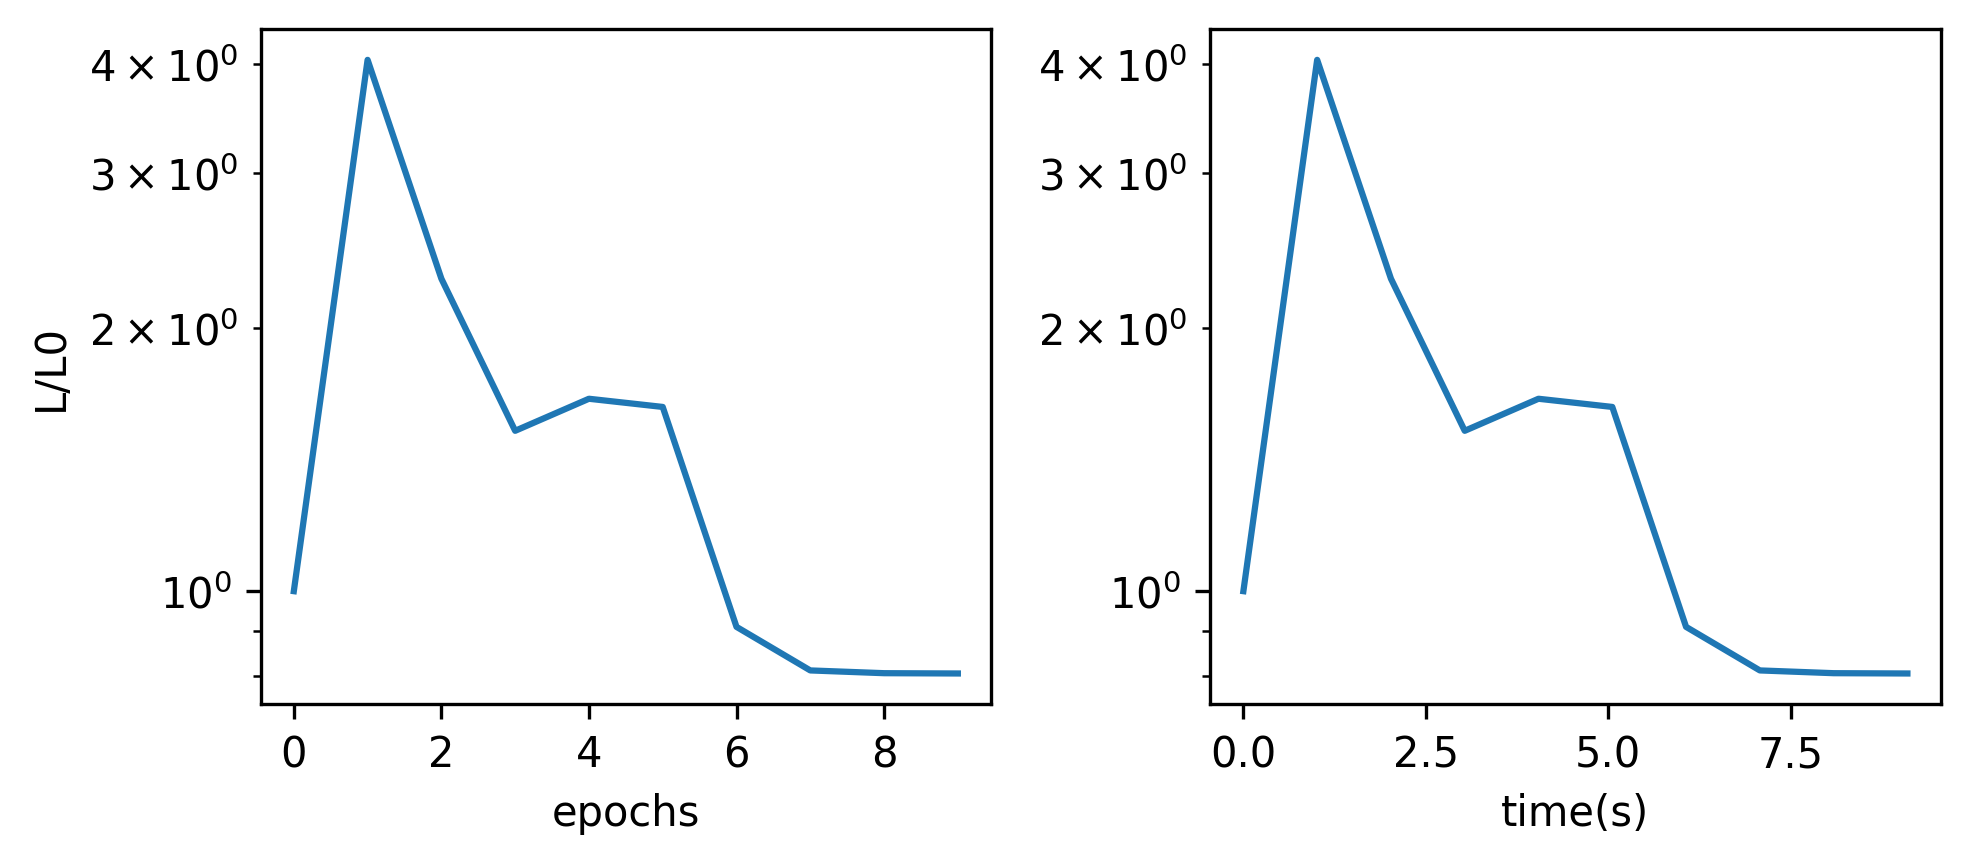

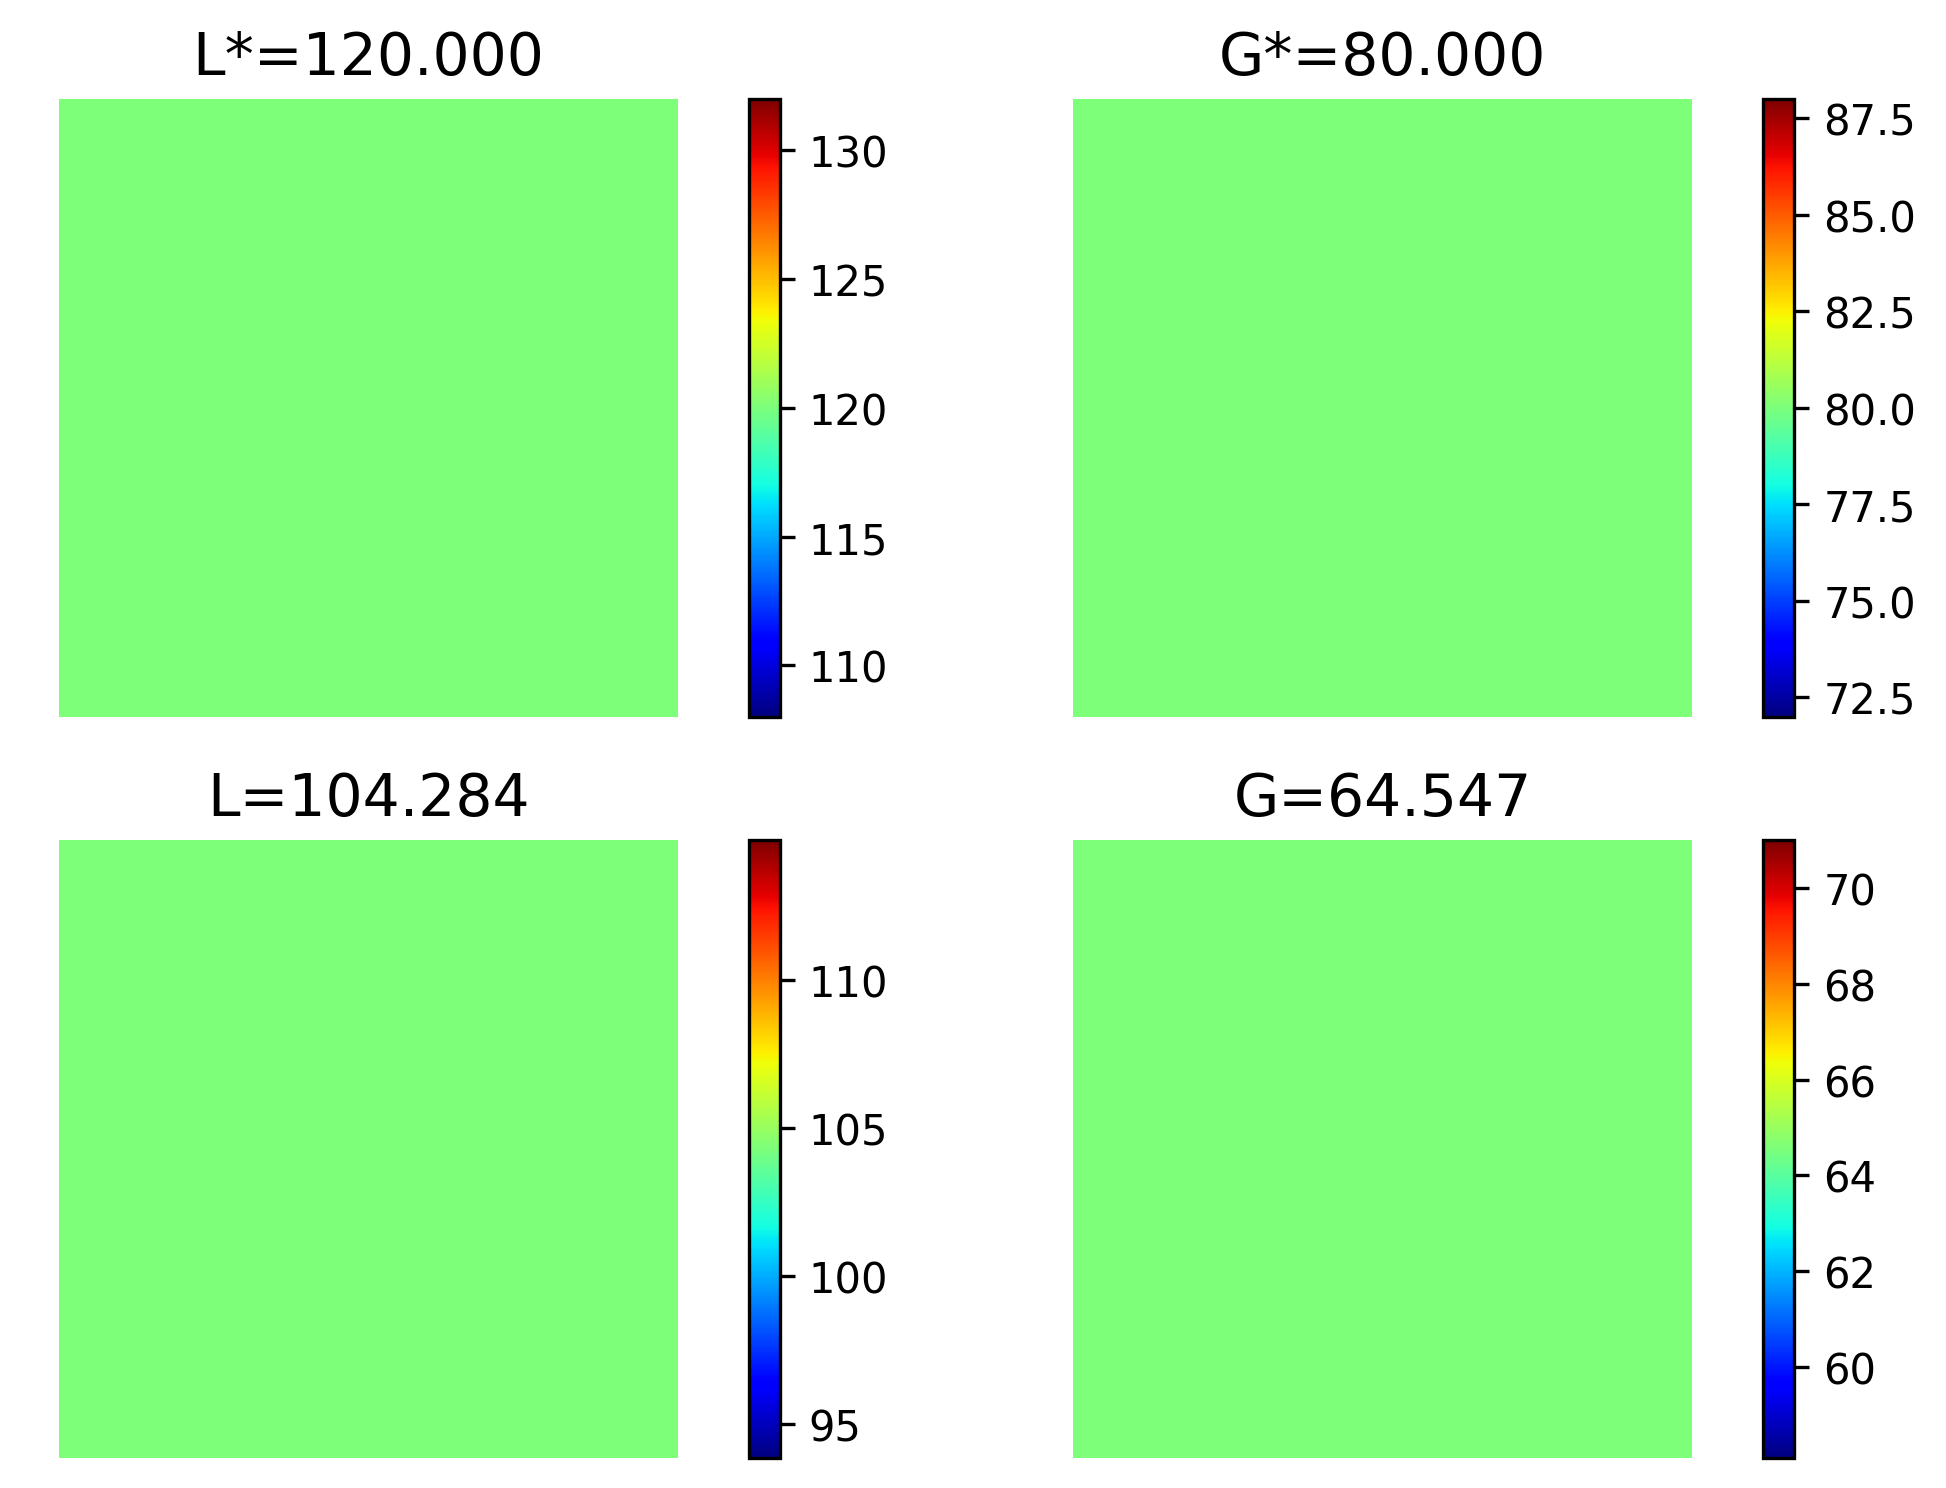

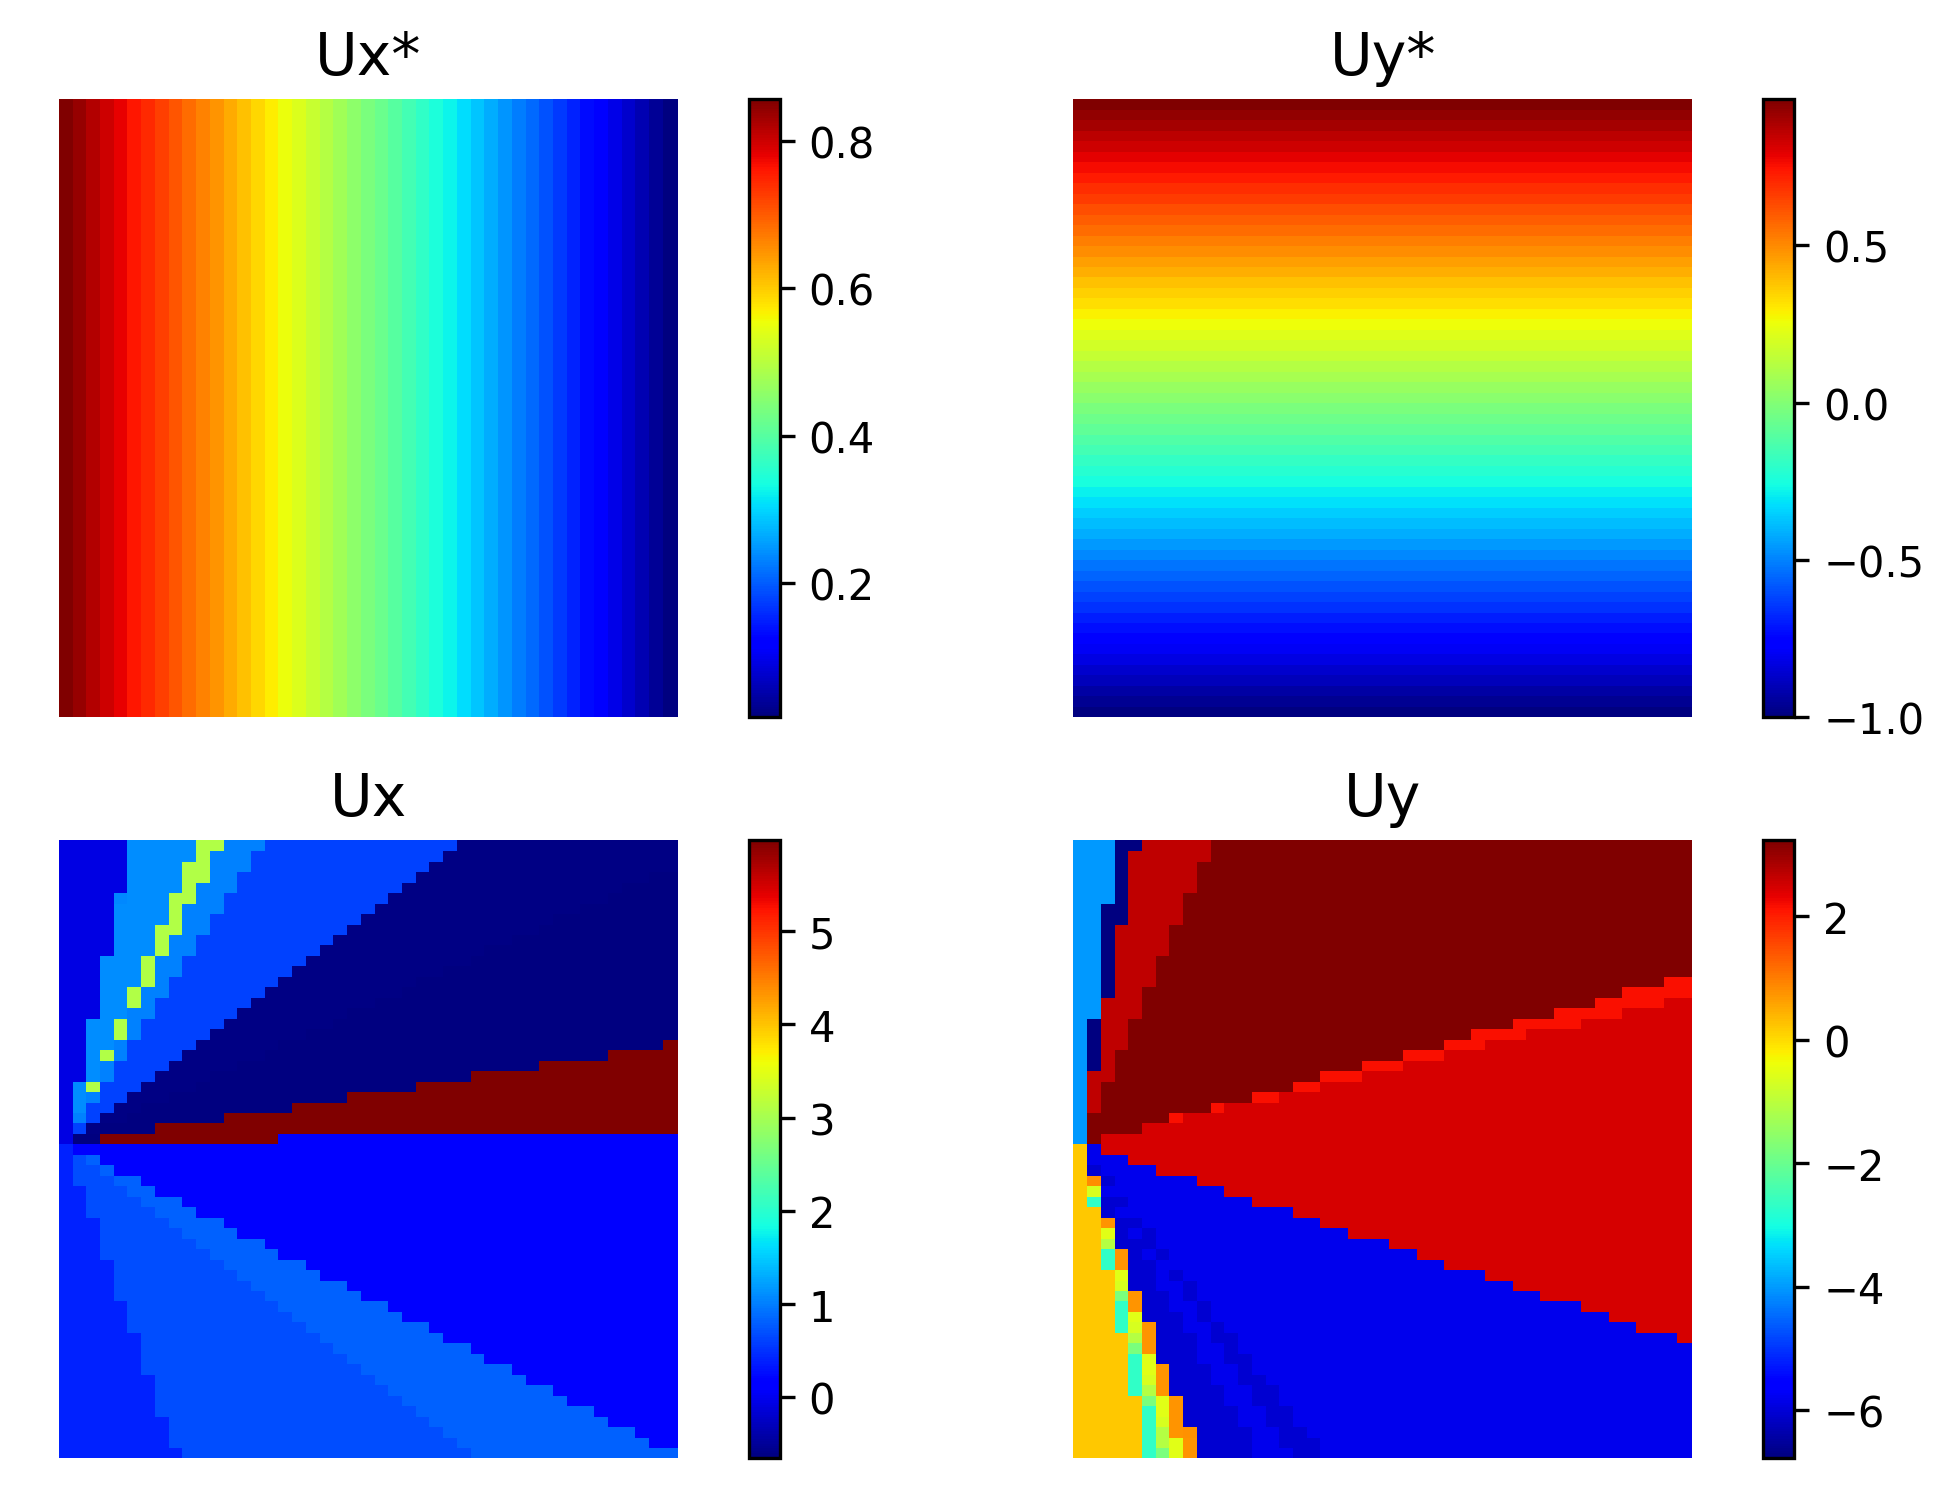

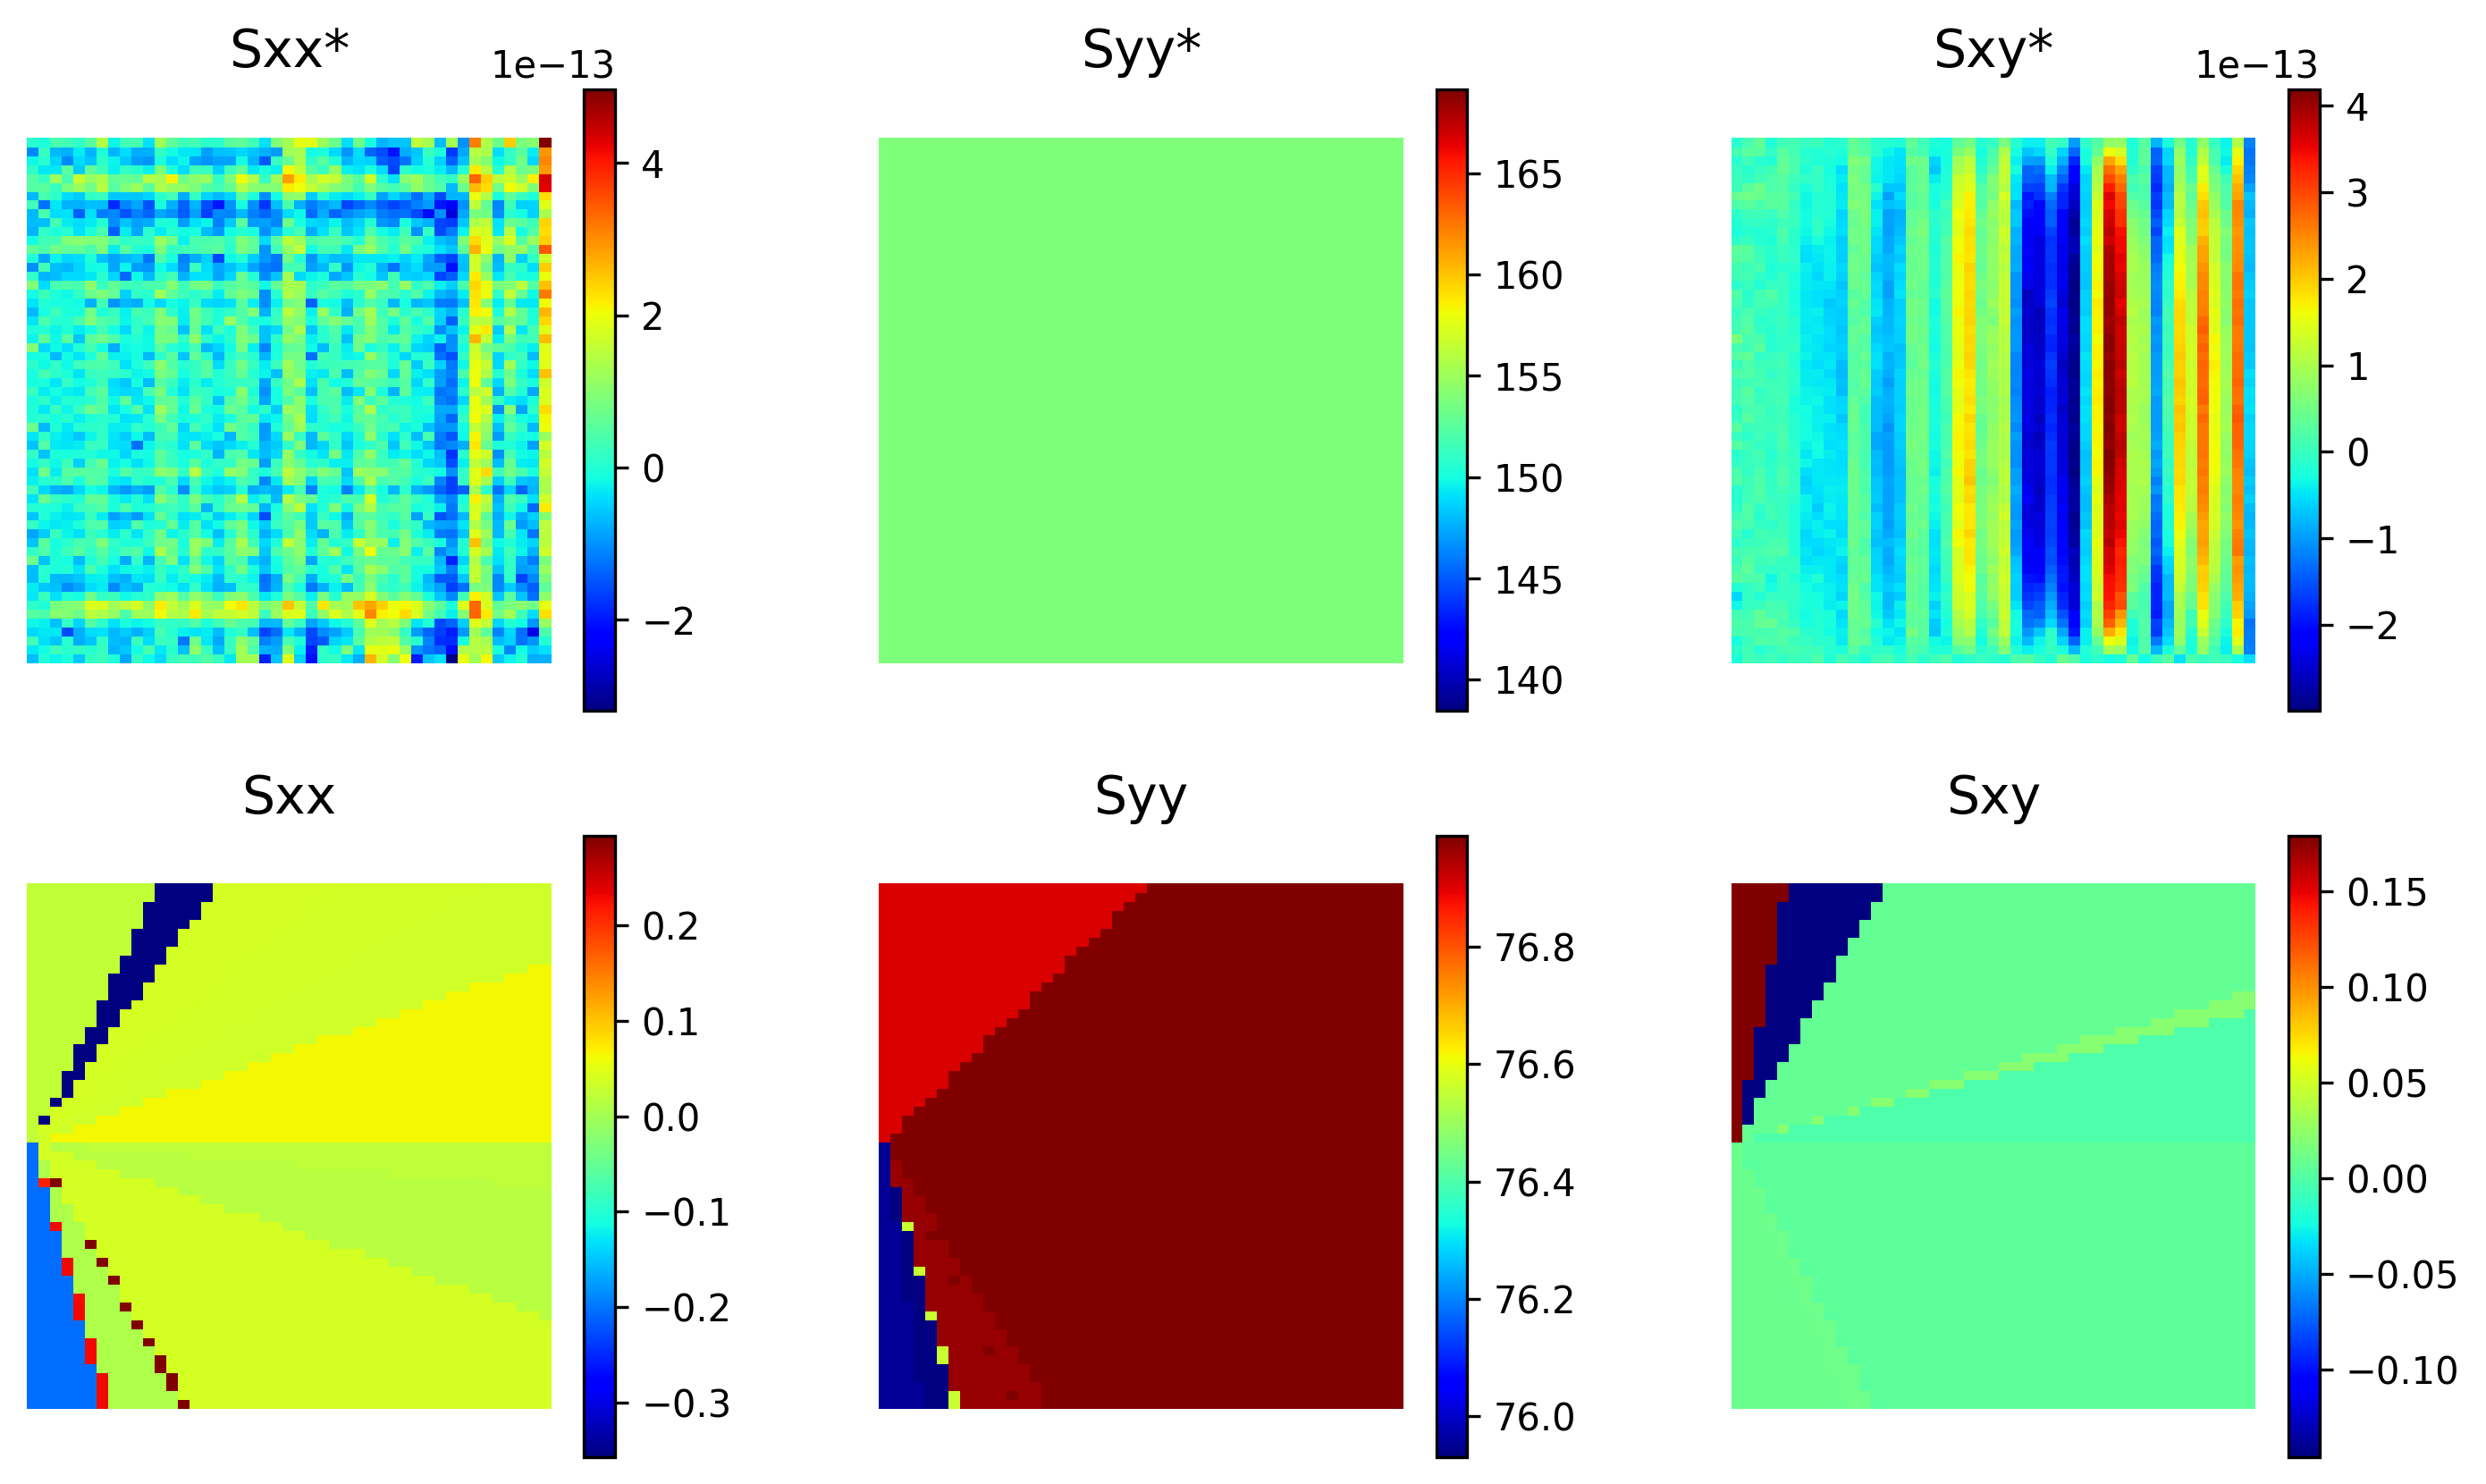

In [16]:
plot()